# Comparing COVID-19 Cases with Election Results

# Todo
- add calculated vars to summary set for correlations
- show the model functions in proper mathmatical syntax
- perform usual tests required before regression
- describe regression results with accurate language
- check comments to make sure they still make sense

# ETL

### Import Utils

In [1]:
import math
import scipy
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

### Import Data

Below are the `covid_confirmed_usafacts`, `npr-2016-election-data`, and `covid_county_population_usafacts` datasets used for our analysis. 

In [2]:
covid_confirmed_facts    = pd.read_csv('covid_confirmed_usafacts.csv')
election_data            = pd.read_csv('npr-2016-election-data.csv')
covid_county_population  = pd.read_csv('covid_county_population_usafacts.csv')

### Confirm Data Integrity
After import we confirm that the data looks correct compared with each dataframes csv. We also confirm that there are now massing values.

In [3]:
covid_confirmed_facts.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,7306,7306,7320,7329,7341,7346,7347,7350,7365,7375
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,22337,22337,22464,22556,22642,22734,22802,22876,23032,23184
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,2367,2367,2373,2377,2386,2389,2394,2396,2411,2415
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,2704,2704,2708,2713,2719,2721,2727,2733,2747,2753


In [4]:
print(covid_confirmed_facts.isnull().sum())

countyFIPS     0
County Name    0
State          0
StateFIPS      0
2020-01-22     0
              ..
2021-07-17     0
2021-07-18     0
2021-07-19     0
2021-07-20     0
2021-07-21     0
Length: 551, dtype: int64


In [5]:
covid_county_population.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [6]:
covid_county_population.isnull().sum()

countyFIPS     0
County Name    0
State          0
population     0
dtype: int64

In [7]:
election_data.head()

,State,Clinton,Trump
0,AK,38,53
1,AL,35,63
2,AR,34,60
3,AZ,45,50
4,CA,62,33


In [8]:
election_data.isnull().sum()

State      0
Clinton    0
Trump      0
dtype: int64

After looking at the top few rows of each table and taking the sum of all missing values per column we can see that the data has been imported correctly. We also won't need to perform any kind of data fill since there are now missing values.

# Data Preperation 

### Aggregate by State

We now drop the `County Name`, `countyFIPS` and `StateFIPS` columns from `covid_confirmed_facts` since they will not be used in our analysis (as it focuses on state only). Once these columns were dropped, we aggregate the covid case data that was by county by state. We name our new aggregated dataframe as `covid_state_cases` since these are now the number of total cummulative cases by state.

In [9]:
covid_confirmed_facts = covid_confirmed_facts.drop(columns=['County Name', 'countyFIPS', 'StateFIPS'])

covid_state_cases = covid_confirmed_facts.groupby('State').sum()

covid_state_cases.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
State,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68977,68977,69189,69189,69453,69453,69453,69891,69891,70328
AL,0,0,0,0,0,0,0,0,0,0,...,555215,555215,556613,557578,558577,559478,560202,560920,562311,563943
AR,0,0,0,0,0,0,0,0,0,0,...,355460,358951,360259,361238,361238,361238,361238,365132,367007,367007
AZ,0,0,0,0,1,1,1,1,1,1,...,901562,901907,903852,904866,906117,906117,906117,909283,910437,911480
CA,0,0,0,0,2,3,3,4,4,4,...,3736534,3736534,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006


Similarly, for our `covid_county_population` dataframe we drop the county related columns `countyFIPS` and `County Name`. We then aggregate populations by state.

In [10]:
covid_county_population = covid_county_population.drop(columns=['countyFIPS', 'County Name'])

covid_state_population = covid_county_population.groupby('State').sum()

covid_state_population.head()

,population
State,
AK,731545
AL,4903185
AR,3017804
AZ,7278717
CA,39512223


### Merge Data Sets

Now that all unecessary columns were removed from our dataframes and all data is aggregated by state, we are able to merge the three dataframes into a single united data frame `pop_case_elec`. Since we know that 

In [11]:
pop_case_elec = covid_state_population.merge(
    covid_state_cases,
    on='State'
).merge(
    election_data,
    on='State'
)

pop_case_elec.head()

,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,Clinton,Trump
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69189,69453,69453,69453,69891,69891,70328,38,53
1,AL,4903185,0,0,0,0,0,0,0,0,...,556613,557578,558577,559478,560202,560920,562311,563943,35,63
2,AR,3017804,0,0,0,0,0,0,0,0,...,360259,361238,361238,361238,361238,365132,367007,367007,34,60
3,AZ,7278717,0,0,0,0,1,1,1,1,...,903852,904866,906117,906117,906117,909283,910437,911480,45,50
4,CA,39512223,0,0,0,0,2,3,3,4,...,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33


### Create Indicator clinton_win

The intention of In[14] and In[15] is to simplify into a binary of which states were won by CLinton or Trump. In[14] will add a column to the DataFrame named 'clinton_win' to display 'False' if Clinton lossed, and 'True' if Clinton won. The purpose of this binary column is to simplify which states voted majority for Trump or Clinton, which will be utilized in establishing correlations between different variables later. We then do some renaming to python standard snake case.

In [12]:
pop_case_elec['clinton_win'] = pop_case_elec['Clinton'] > pop_case_elec['Trump']

pop_case_elec = pop_case_elec.rename( columns={ 'State':'state', 'Clinton':'clinton', 'Trump':'trump' } )

pop_case_elec.head()

,state,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,clinton,trump,clinton_win
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69453,69453,69453,69891,69891,70328,38,53,False
1,AL,4903185,0,0,0,0,0,0,0,0,...,557578,558577,559478,560202,560920,562311,563943,35,63,False
2,AR,3017804,0,0,0,0,0,0,0,0,...,361238,361238,361238,361238,365132,367007,367007,34,60,False
3,AZ,7278717,0,0,0,0,1,1,1,1,...,904866,906117,906117,906117,909283,910437,911480,45,50,False
4,CA,39512223,0,0,0,0,2,3,3,4,...,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33,True


### Cases Time Series

Insert Notes

In [13]:
cases_ts = pop_case_elec.iloc[:, :-6]

cases_ts = cases_ts.set_index('state')

cases_ts = cases_ts.drop(columns=['population'])

cases_ts.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-09,2021-07-10,2021-07-11,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18
state,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68793,68793,68793,68977,68977,69189,69189,69453,69453,69453
AL,0,0,0,0,0,0,0,0,0,0,...,554071,554605,554605,555215,555215,556613,557578,558577,559478,560202
AR,0,0,0,0,0,0,0,0,0,0,...,355460,355460,355460,355460,358951,360259,361238,361238,361238,361238
AZ,0,0,0,0,1,1,1,1,1,1,...,899830,899830,899830,901562,901907,903852,904866,906117,906117,906117
CA,0,0,0,0,2,3,3,4,4,4,...,3724362,3724362,3724362,3736534,3736534,3739625,3743242,3747897,3747897,3747897


## Add Calculated Data

The following section contains all of the correlations we were supposed to show. In our correltions, we fitted our logistics model to all correltions to see if it'd be a good indicator between the following correlations.

### Modeling

The following section contains our regression funciton, logistic_model funciton, linear_model function and make_projection function. 

The following regression function is made to interact with the curve_fit package in scipy.optimize import. The following function will find the covariance and betas for a correlation when applying the logistics model.

In [14]:
from scipy.optimize import curve_fit

def regression( model, x_data, y_data ):
    found_betas = []
    covariance  = 0
    
    found_betas, covariance = curve_fit( model, x_data, y_data )
        
    return found_betas, covariance

The logistic_model function is used to fit in our correlations made. 

In [15]:
def logistic_model( x, beta_0, beta_1, beta_2 ):
    return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x ))) 

The linear_model was used prior to applying our logistics model to our correlations. This was used as a test to ensure our other functions interacted properly with the model. 

In [16]:
def linear_model( x, beta_0, beta_1 ):
    return ( beta_0 * x ) + beta_1

The make_projections model interacts with either our linear_model or logistic_model functions and the pop_case_elec DataFrame. 

In [17]:
def make_projection( model, x_data, y_data, points ):     
    betas, covariance = regression( model, x_data, y_data )
    
    x_proj = np.linspace( 0, points, num=points )
    y_proj = model( x_proj, *betas )
    
    return x_proj, y_proj

In [18]:
def project_max( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    x_proj, y_proj = make_projection( logistic_model, x_data, y_data, 2000 )
    
    return np.round(np.max(y_proj))

In [19]:
def get_max_inc( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    found_betas, covariance = regression( logistic_model, x_data, y_data )
    
    return found_betas[2]

Using the make_projections function, we are able to use our logistic_model to fit to our correlations. Assuming the correlaitons are similiar to the logistic_model output, we can further explore the correlation using a hypothesis test. 

## Case Projections

Below contains all code that utlizes the pop_case_election DataFrame to show correlation between different variables. 

### Projected Max Cases Visualization

We want to use our logistic_model to see if it would be a good predictor for cases in MA vs days passed. 

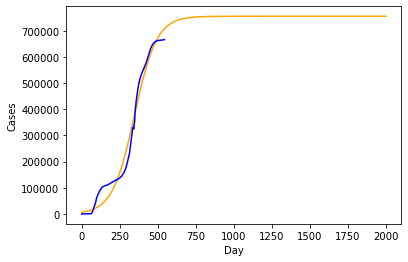

PROJECTED MAX CASES:
755393.0


In [20]:
ma_cases = cases_ts.loc['MA']

num_days = ma_cases.shape[0]
days = np.linspace( 0, num_days, num=num_days )


days_proj = 2000
days_proj, case_proj = make_projection( logistic_model, days, ma_cases, days_proj )

_ = plt.plot( days_proj, case_proj, color='orange' )
_ = plt.plot( days, ma_cases, color='blue' ) 

_ = plt.xlabel('Day')
_ = plt.ylabel('Cases')

plt.show()

print('PROJECTED MAX CASES:')
print(np.round(np.max(case_proj)))

Based off this result, we can see our logistic model (in orange) can be a good model to be used to predict cases in MA. 

In [21]:
projected = cases_ts.aggregate( func=project_max, axis=1 )

pop_case_elec = pop_case_elec.merge( projected.to_frame(name='projected_max'), on='state')

<ipython-input-15-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


In [22]:
pop_case_elec['projected_max_per_cap'] = pop_case_elec['projected_max'] / pop_case_elec['population'] 

In [23]:
projected = cases_ts.aggregate( func=get_max_inc, axis=1 )

pop_case_elec = pop_case_elec.merge( projected.to_frame(name='time_max_inc'), on='state')

<ipython-input-15-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


In [24]:
total_days = pop_case_elec.shape[1]

pop_case_elec['avg_rate_increase'] = ( pop_case_elec['2021-07-21'] - pop_case_elec['2020-01-22'] ) / total_days

# Model Planning

### Summary Dataframe

The below code was done to show a summary of the pop_case_elec DataFrame. This DataFrame will be named sum_pop_case_elec. 

To make sum_pop_case_elec, we dropped all case columns except for the '2021-07-21' column, which displays the cumulative cases on  up to 7/21/2021. This was saved as 'total_cases'. 

Next we computed the 'month_cases' column, which gives the cases for the past month. This was done by subtracting cumlative cases on 7/21/2021 by cumulative cases on 6/21/2021. 

The 'cases_per_cap' column was added by dividing the 'total_cases' column by the 'population' column. 

These new columns will be referenced when looking into different correlations later. 

In [25]:
sum_pop_case_elec = pop_case_elec

sum_pop_case_elec['total_cases'] = pop_case_elec['2021-07-21']
sum_pop_case_elec['cases_per_cap'] = sum_pop_case_elec['total_cases'] / sum_pop_case_elec['population']

sum_pop_case_elec = sum_pop_case_elec.drop(sum_pop_case_elec.iloc[:, 2:-5], axis=1)

sum_pop_case_elec.head()

,state,population,projected_max_per_cap,time_max_inc,avg_rate_increase,total_cases,cases_per_cap
0,AK,731545,0.091394,323.874138,126.717117,70328,0.096136
1,AL,4903185,0.117014,313.166397,1016.113514,563943,0.115016
2,AR,3017804,0.118822,315.013886,661.273874,367007,0.121614
3,AZ,7278717,0.130498,325.383255,1642.306306,911480,0.125225
4,CA,39512223,0.098148,325.727260,6796.407207,3772006,0.095464


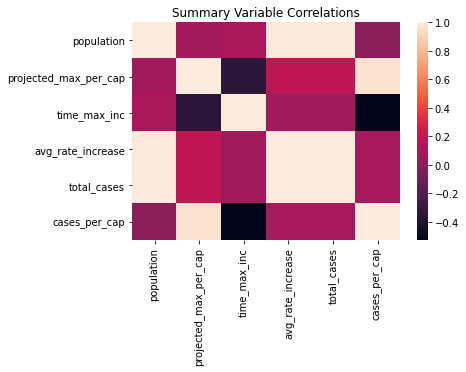

In [26]:
_ = sns.heatmap( sum_pop_case_elec.corr() )

_ = plt.title('Summary Variable Correlations')

plt.show()

# Model Building

In [ ]:
def state_covid_cases(state):
    chosen_state = pop_case_elec[pop_case_elec['state'] == state]
    return chosen_state

state= str(input("Enter State Abbreviation:"))

state_covid_cases(state)